In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os


import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [ ]:
import PIL.Image
import time
import functools

In [4]:
# define the tensor to image function
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)

    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [111]:
content_fp = '../data/harold.jpg'
style_fp = '../data/disco/112_RdS3nVJ.jpeg'

In [112]:
# content = tf.keras.utils.load_img(content_fp)
# style = tf.keras.utils.load_img(style_fp)

In [113]:
def load_img(path_to_image):
    max_dim=512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # calculate the new dimensions of the image based on a max side length of 512
    shape = tf.cast(tf.shape(img)[:-1],tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim
    new_shape = tf.cast(shape*scale,tf.int32)

    # resize the  image to the new shape and return
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img


In [114]:
# function to display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image,axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


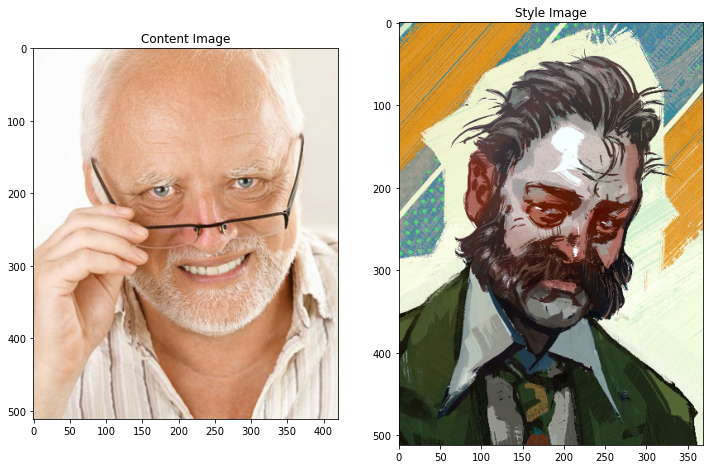

In [115]:
content = load_img(content_fp)
style = load_img(style_fp)

plt.subplot(1,2,1)
imshow(content, 'Content Image')
plt.subplot(1,2,2)
imshow(style, "Style Image")

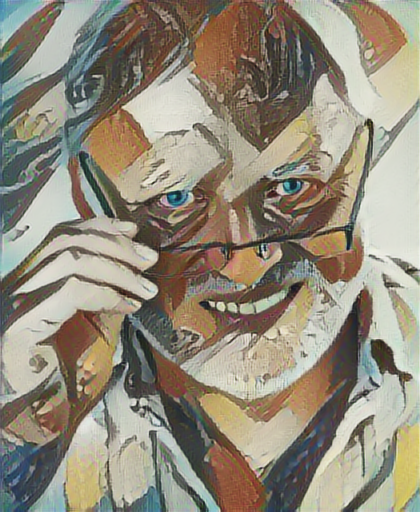

In [116]:
import tensorflow_hub as hub
import PIL
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content), tf.constant(style))[0]
tensor_to_image(stylized_image)

In [117]:
# Implementing Style Transfer Algorithm:
# Per Gatys et. al. (2015)
x = tf.keras.applications.vgg19.preprocess_input(content*255)
x = tf.image.resize(x,(224,224))

vgg = tf.keras.applications.VGG19(include_top=True,weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [118]:
# define the training schedule

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name,prob) in predicted_top_5]

[('lab_coat', 0.28755447),
 ('sunscreen', 0.06077368),
 ('wig', 0.054912746),
 ('Windsor_tie', 0.045255),
 ('neck_brace', 0.03488019)]

In [119]:
vgg = tf.keras.applications.VGG19(include_top=False,weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_8
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [124]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv1',
                'block4_conv3',
                'block5_conv1']

In [125]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [126]:
def vgg_layers(layer_names):

    vgg = tf.keras.applications.VGG19(include_top=False,weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input],outputs)
    return model

In [127]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print("shape: ", output.numpy().shape)
    print("min: ", output.numpy().min())
    print("max: ",output.numpy().max())
    print("mean: ", output.numpy().mean())
    print()

block1_conv2
shape:  (1, 512, 369, 64)
min:  0.0
max:  2727.3357
mean:  155.97792

block2_conv2
shape:  (1, 256, 184, 128)
min:  0.0
max:  7151.953
mean:  142.30466

block3_conv1
shape:  (1, 128, 92, 256)
min:  0.0
max:  10684.129
mean:  160.51135

block4_conv3
shape:  (1, 64, 46, 512)
min:  0.0
max:  13639.754
mean:  208.71051

block5_conv1
shape:  (1, 32, 23, 512)
min:  0.0
max:  3323.2515
mean:  49.796196



In [128]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bikd->bcd', input_tensor,input_tensor)

    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/num_locations

In [129]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self,style_layers,content_layers):

        super(StyleContentModel,self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):

        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(out) for out in style_outputs]

        content_dict = {content_name : value for content_name, value in zip(self.content_layers,content_outputs)}

        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [130]:
extractor = StyleContentModel(style_layers,content_layers)
results = extractor(tf.constant(content))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())



Styles:
   block1_conv2
    shape:  (1, 64, 64)
    min:  1251.1365
    max:  232801070.0
    mean:  4357567.5

   block2_conv2
    shape:  (1, 128, 128)
    min:  18469.092
    max:  28534596.0
    mean:  1427302.2

   block3_conv1
    shape:  (1, 256, 256)
    min:  738.7717
    max:  16468964.0
    mean:  903839.94

   block4_conv3
    shape:  (1, 512, 512)
    min:  20.937843
    max:  10912112.0
    mean:  832836.25

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  748965.7
    mean:  28634.934

Contents:
   block5_conv2
    shape:  (1, 32, 26, 512)
    min:  0.0
    max:  1225.4104
    mean:  13.180084


In [131]:
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [132]:
image = tf.Variable(content)

In [133]:
def clip(image):
    return tf.clip_by_value(image, clip_value_min=0.0,clip_value_max=1.0)

In [134]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02,decay=0.99,clipnorm=1e-1)

In [135]:
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss  = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

In [136]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss,image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip(image))

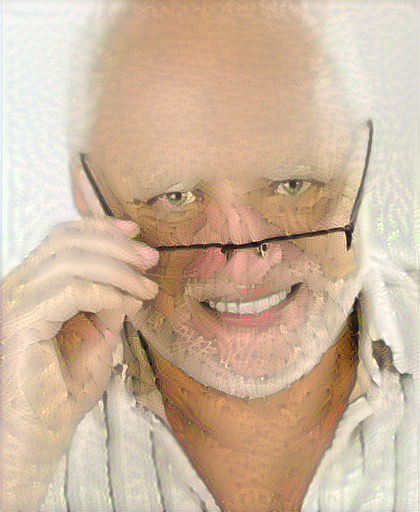

In [81]:
for i in range(1000):
    train_step(image)
tensor_to_image(image)

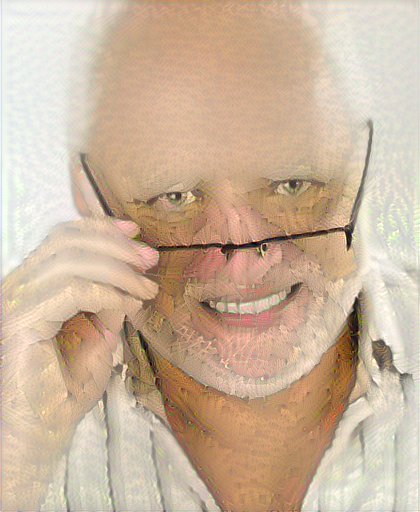

train step: 1000
Total time: 1003.4


In [82]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step +=1
        train_step(image)
        print('.',end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("train step: {}".format(step))

end = time.time()

print ("Total time: {:.1f}".format(end-start))

In [84]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:,:] - image[:, :, :-1,:]
    y_var = image[:, 1:, :,:] - image[:, :-1, :,:]
    return x_var, y_var

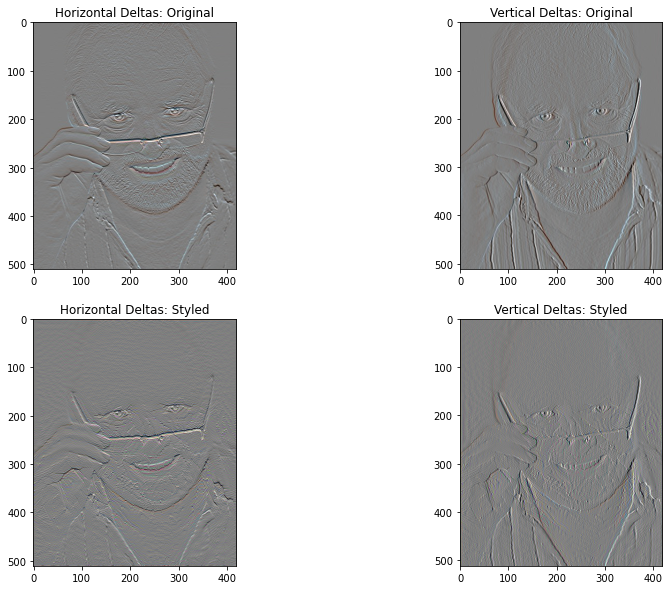

In [85]:
x_deltas, y_deltas = high_pass_x_y(content)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip(2*y_deltas+0.5),"Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip(2*x_deltas+0.5), "Vertical Deltas: Styled")

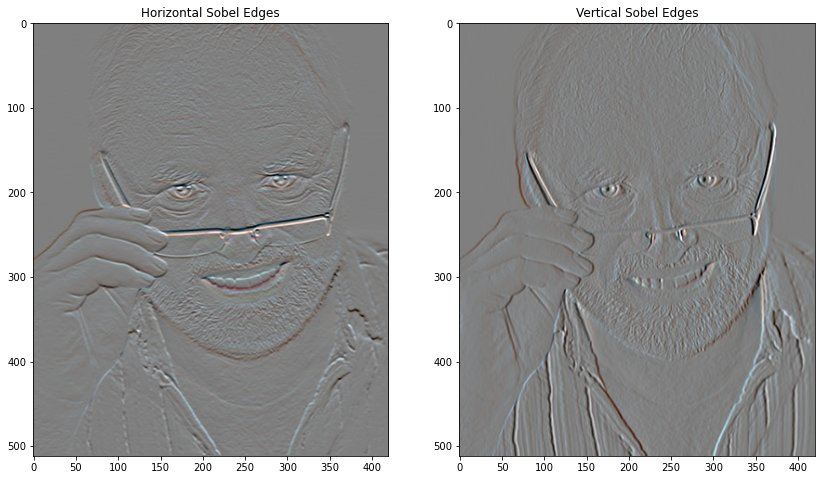

In [86]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content)
plt.subplot(1,2,1)
imshow(clip(sobel[...,0]/4+0.5), "Horizontal Sobel Edges")

plt.subplot(1,2,2)
imshow(clip(sobel[...,1]/4+0.5), "Vertical Sobel Edges")

In [87]:
# the regularization loss associated with this is the sum of the squares of the values

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas))+ tf.reduce_sum(tf.abs(y_deltas))

In [88]:
total_variation_loss(image).numpy()

33922.207

In [89]:
tf.image.total_variation(image).numpy()

array([33922.207], dtype=float32)

In [90]:
total_variation_weight = 27

In [92]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image)

    grad = tape.gradient(loss,image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip(image))

In [93]:
image = tf.Variable(content)

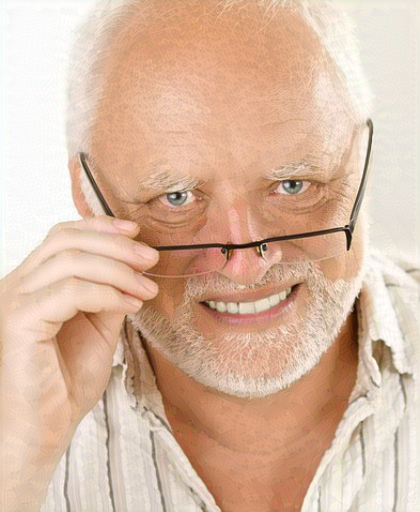

train step: 1000
Total time: 1072.9


In [95]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step +=1
        train_step(image)
        print('.',end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("train step: {}".format(step))

end = time.time()

print ("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = '../output/stylized.png'
tensor_to_image(image).save(file_name)

